#For Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Project-DL-Seq2Seq-master/handwriting synthesis')

In [3]:
%cd '/content/drive/MyDrive/Project-DL-Seq2Seq-master/handwriting synthesis'

/content/drive/MyDrive/Project-DL-Seq2Seq-master/handwriting synthesis


#Models training

In [ ]:
!python main_uncond.py

In [ ]:
!python main_congen.py

#Unconditional Generation

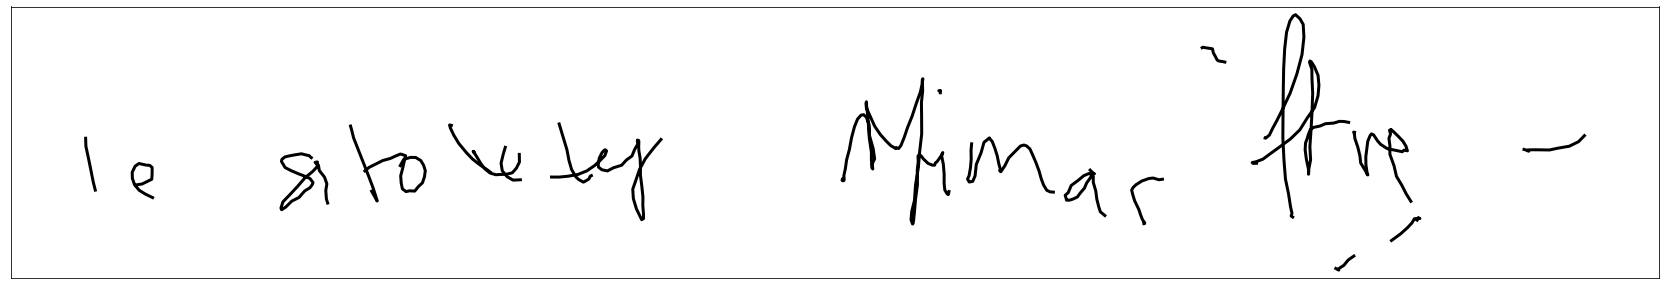

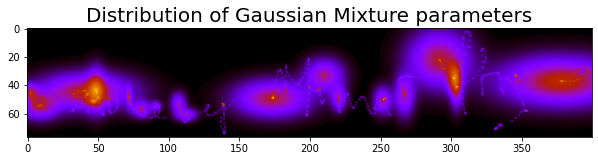

In [5]:
from eval_hand import load_pretrained_uncond, gauss_params_plot, plot_stroke
from model import sample_uncond

lr_model, h_size = load_pretrained_uncond('model_uncond_origin.pt')

for k in range(1):
  strokes, mix_params = sample_uncond(lr_model, h_size, random_state=k+94)
  plot_stroke(strokes)
  gauss_params_plot(mix_params)

#Conditional Generation

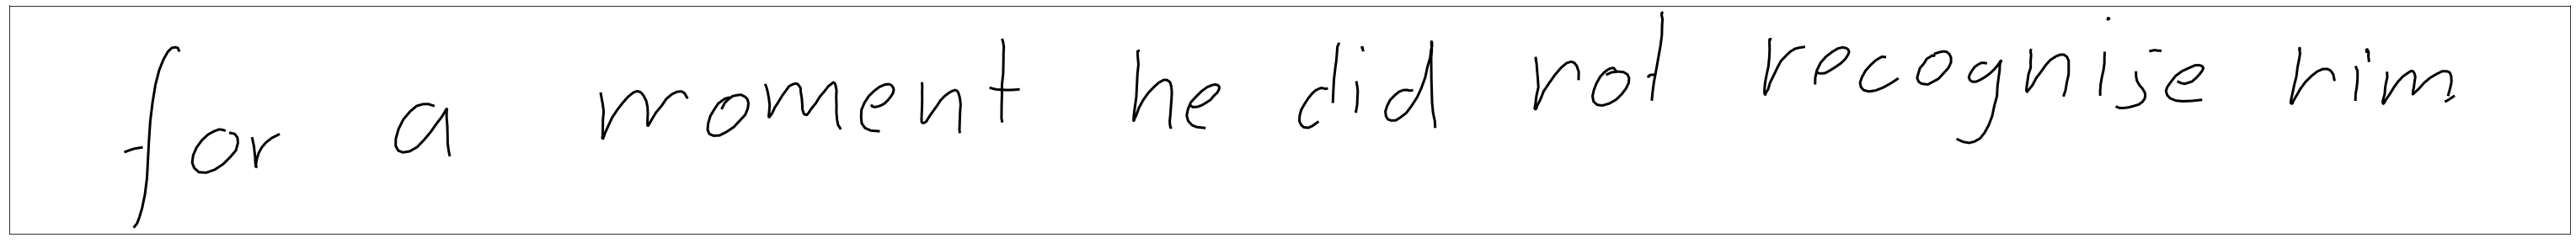

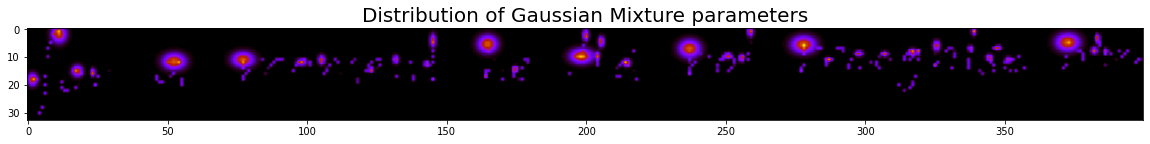

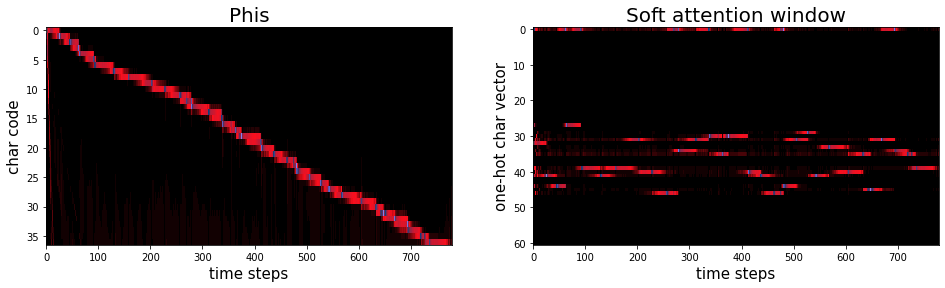

In [6]:
from eval_hand import load_pretrained_congen, gauss_params_plot, plot_stroke, phi_window_plots
from model import sample_congen

lr_model, char_to_vec, h_size = load_pretrained_congen('model_congen_origin.pt')
for k in range(1):
  strokes, mix_params, phi, win = sample_congen(lr_model, 'for a moment he did not recognise him', char_to_vec, h_size,random_state=94+k)
  plot_stroke(strokes)
  gauss_params_plot(mix_params)
  phi_window_plots(phi, win) 

## Attention Mecanism

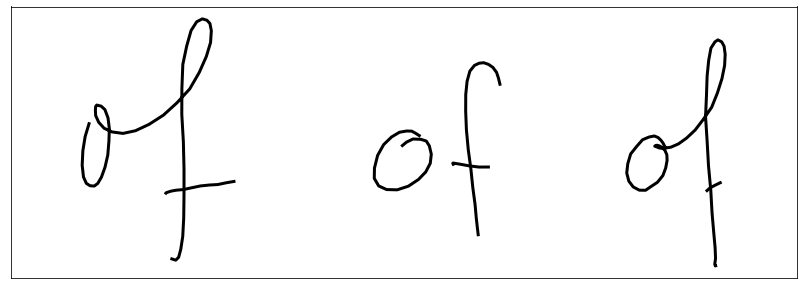

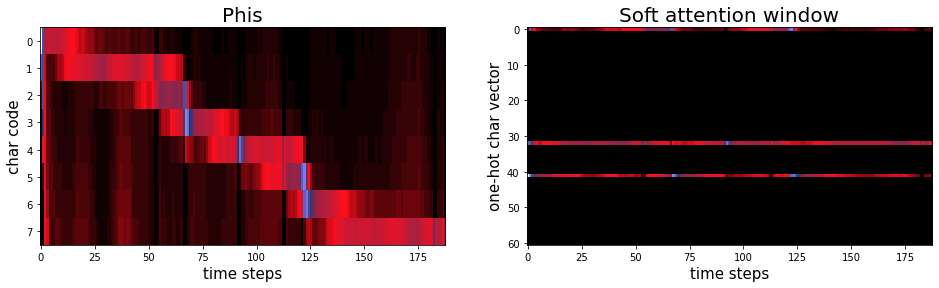

In [7]:
for k in range(1):
  stroke, mix_params, phi, win = sample_congen(lr_model, 'of of of', char_to_vec, h_size,random_state=12)
  plot_stroke(stroke)
  phi_window_plots(phi, win) 

## Cleanliness / Diversity

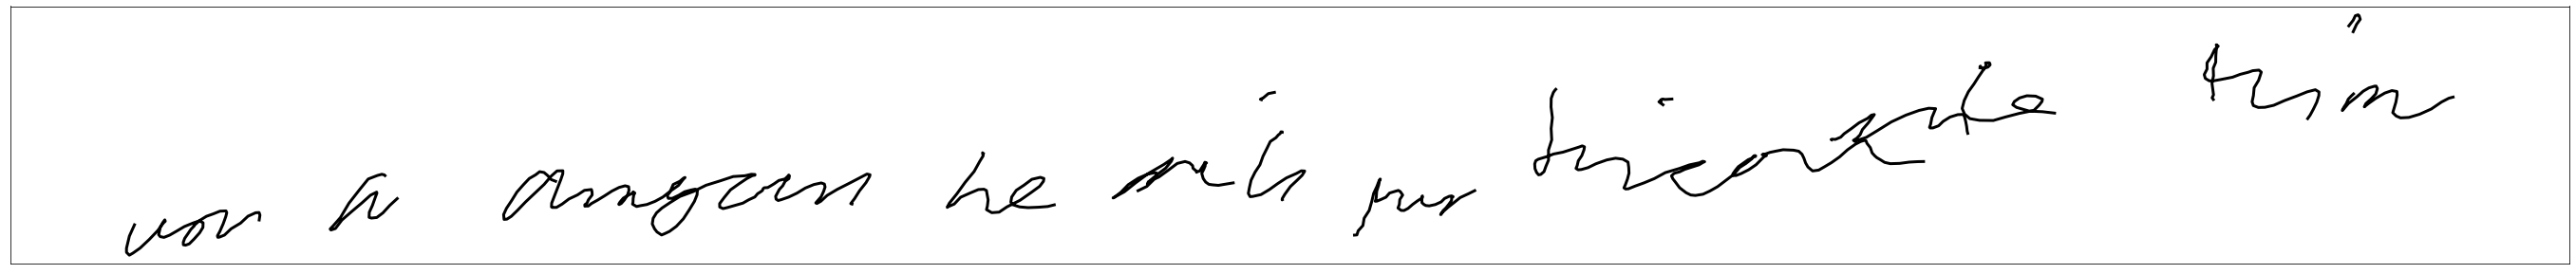

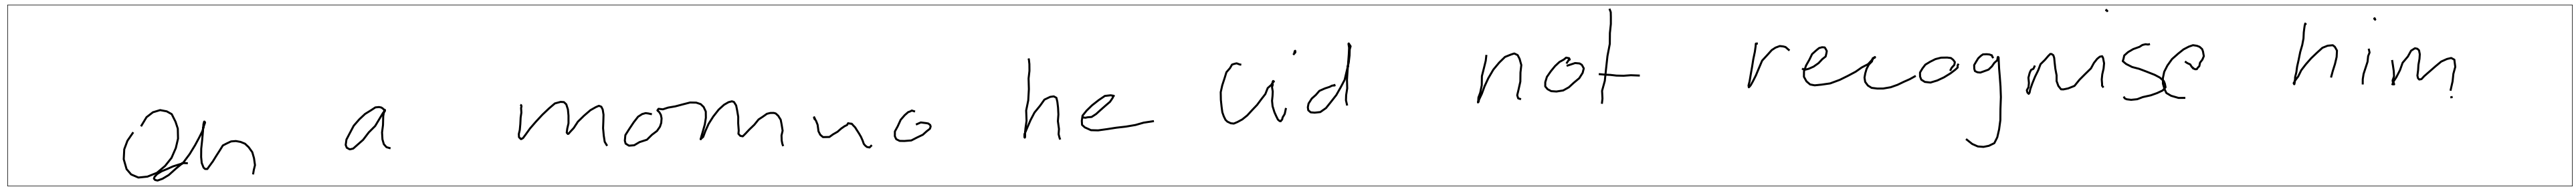

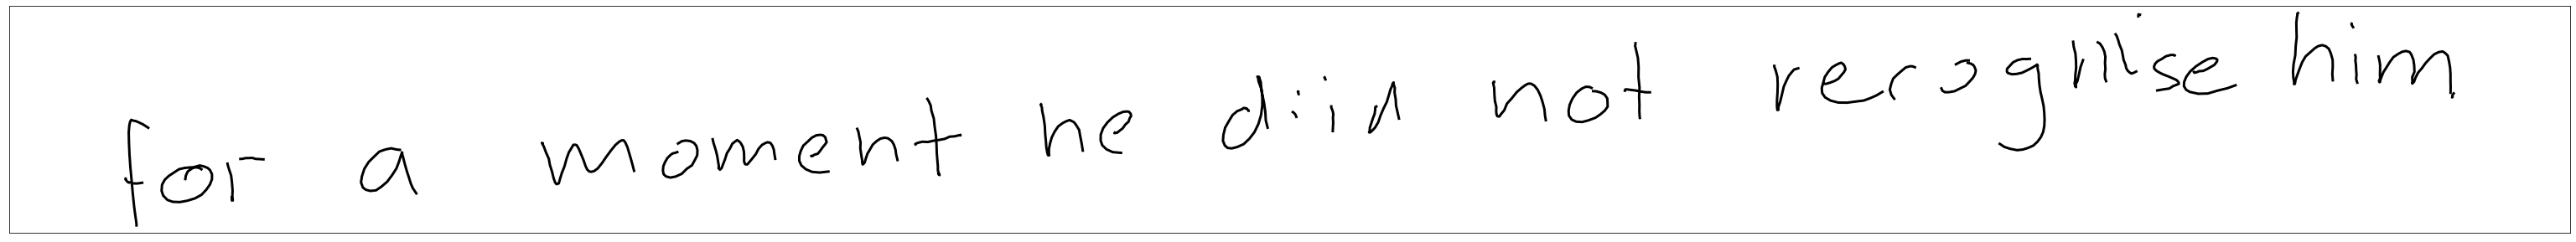

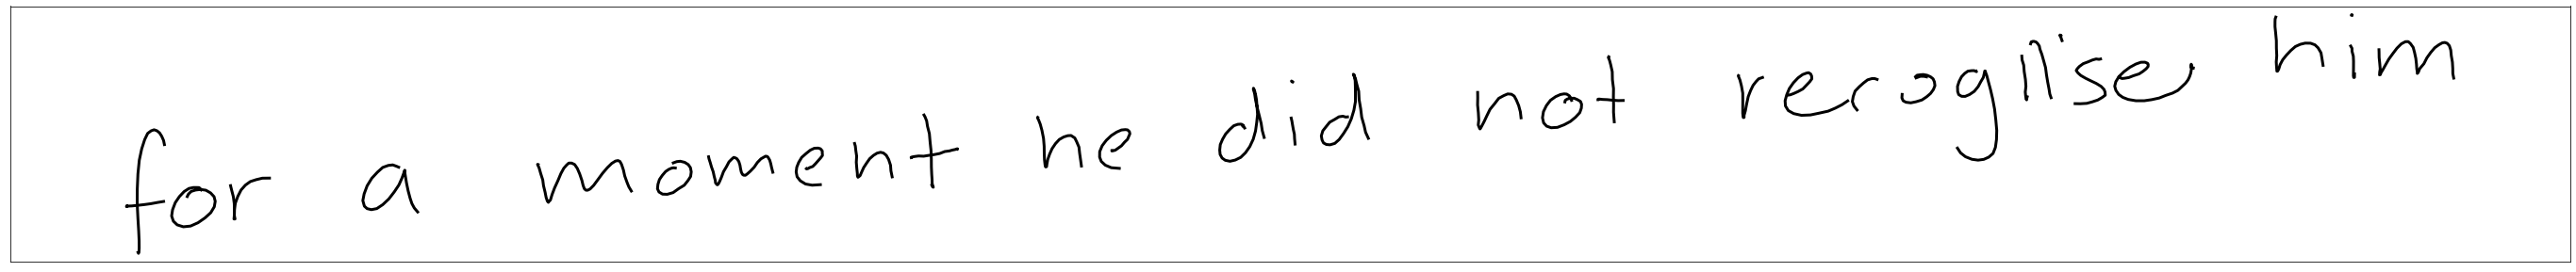

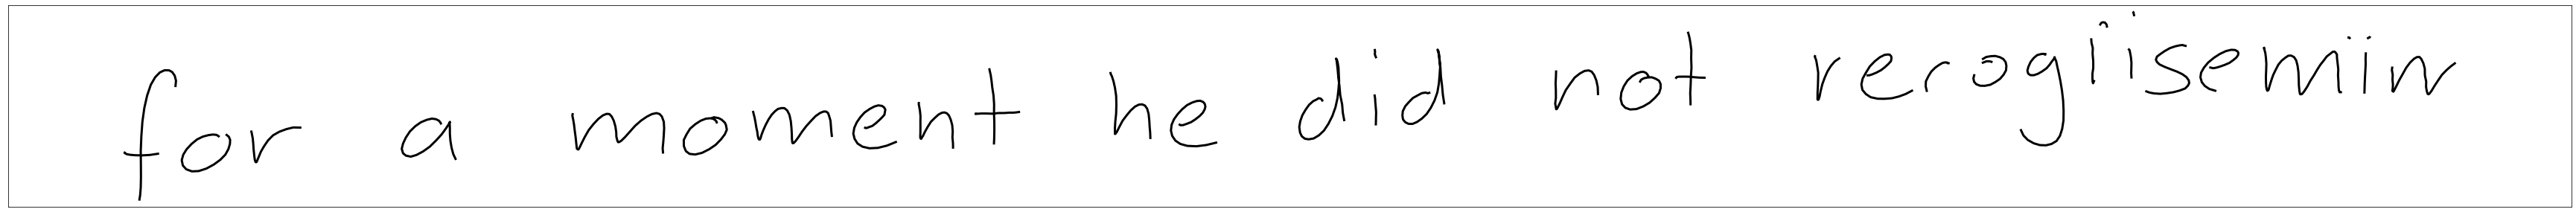

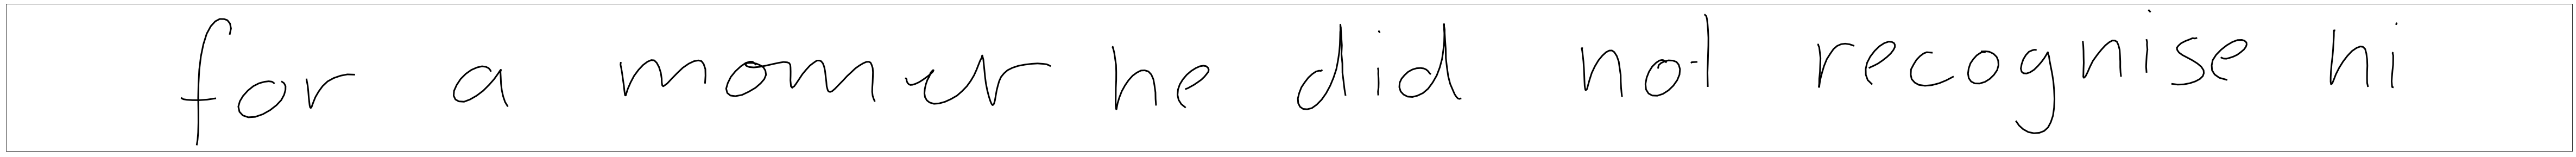

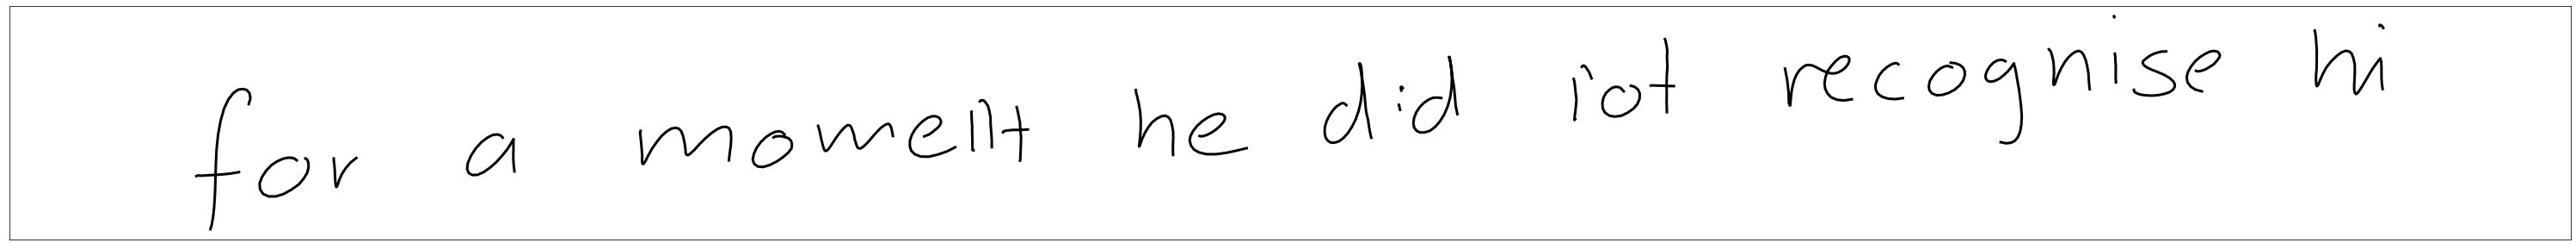

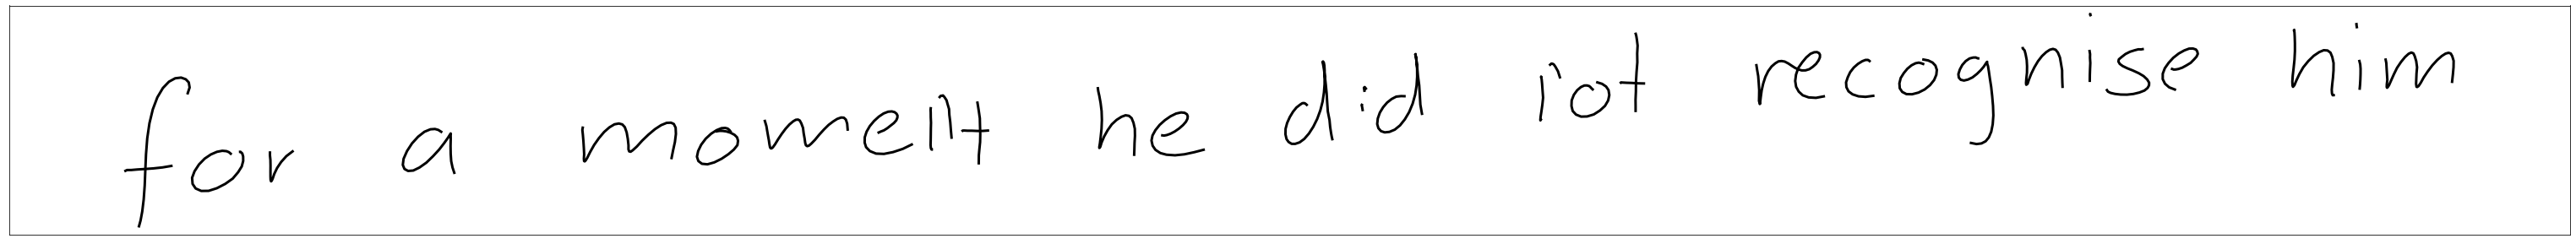

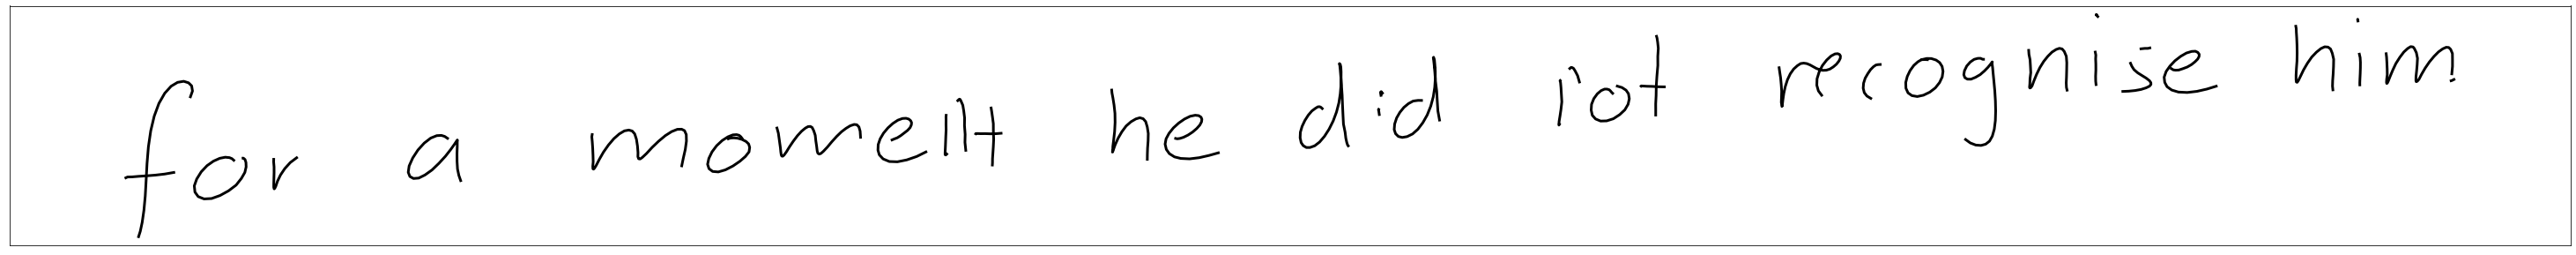

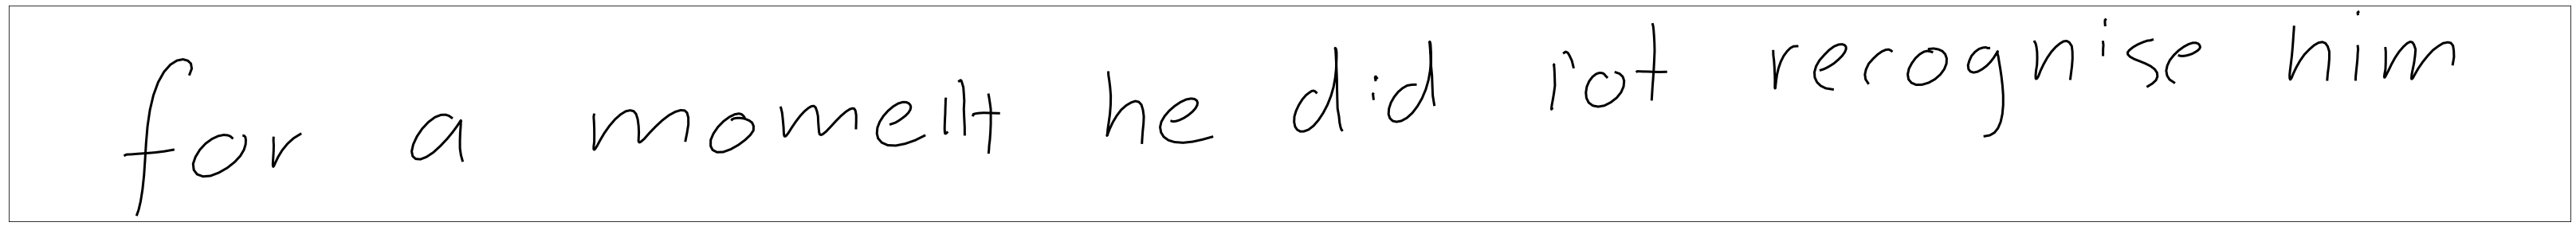

In [ ]:
lr_model, char_to_vec, h_size = load_pretrained_congen('model_congen_origin.pt')
for k in range(10):
  strokes, mix_params, phi, win = sample_congen(lr_model, 'for a moment he did not recognise him', char_to_vec, h_size,random_state=10, bias1=k*0.4, bias2=k*0.4)
  plot_stroke(strokes)

## Primed sampling

In [9]:
#we implement the primed sampling function in the model.py file
from eval_hand import load_pretrained_congen, gauss_params_plot, plot_stroke, phi_window_plots
from model import sample_congen, sample_congen_primed

In [10]:
lr_model, char_to_vec, h_size = load_pretrained_congen('model_congen_origin.pt')

In [11]:
from data_load import strokes, texts

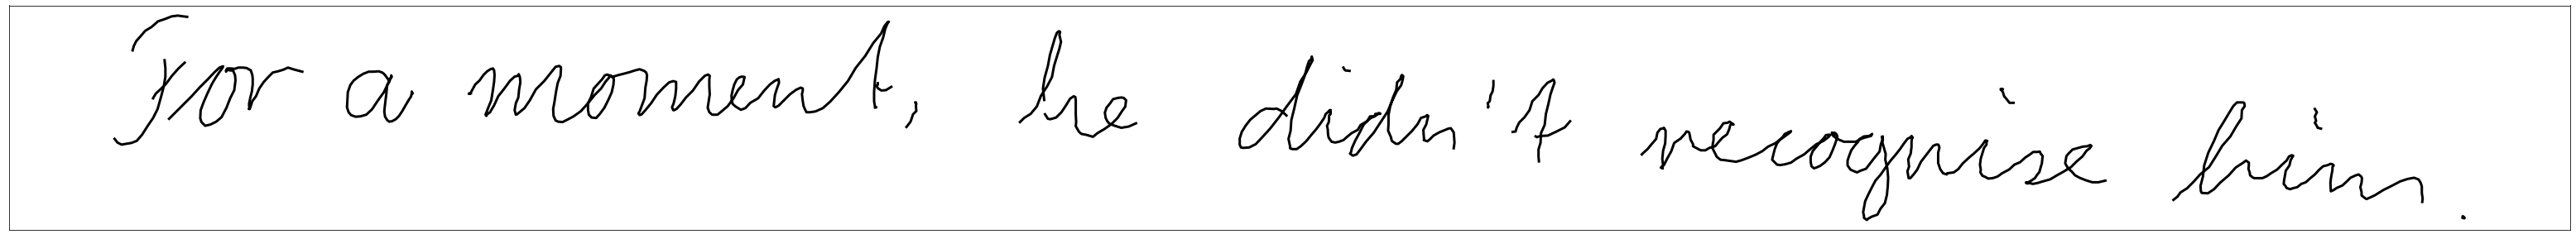

In [12]:
ind=40
plot_stroke(strokes[ind])

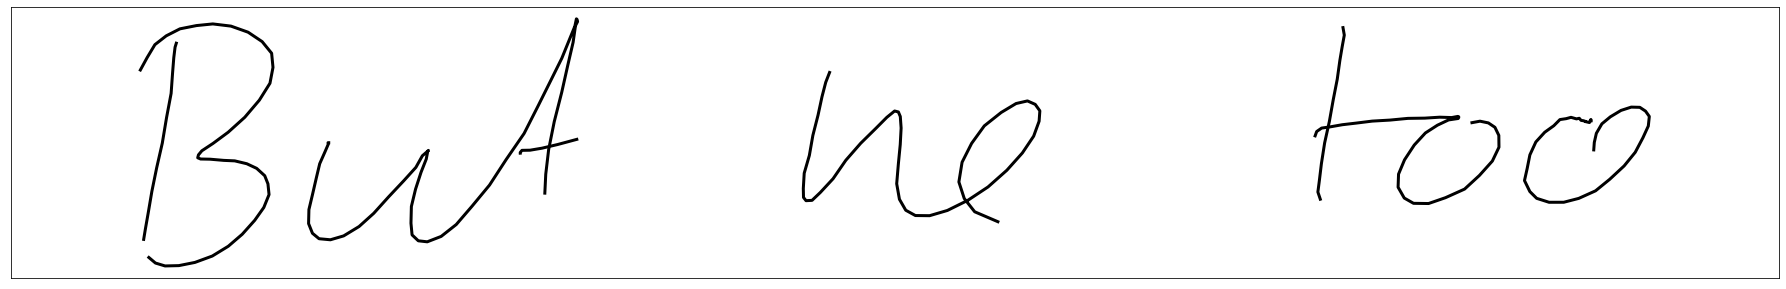

In [13]:
stroke, mix_params, phi, win = sample_congen_primed(lr_model, texts[ind],' But he too.',strokes[ind], char_to_vec, h_size, random_state=10, bias1=1, bias2=1, time_step=1000)
plot_stroke(stroke)

### Without transition word

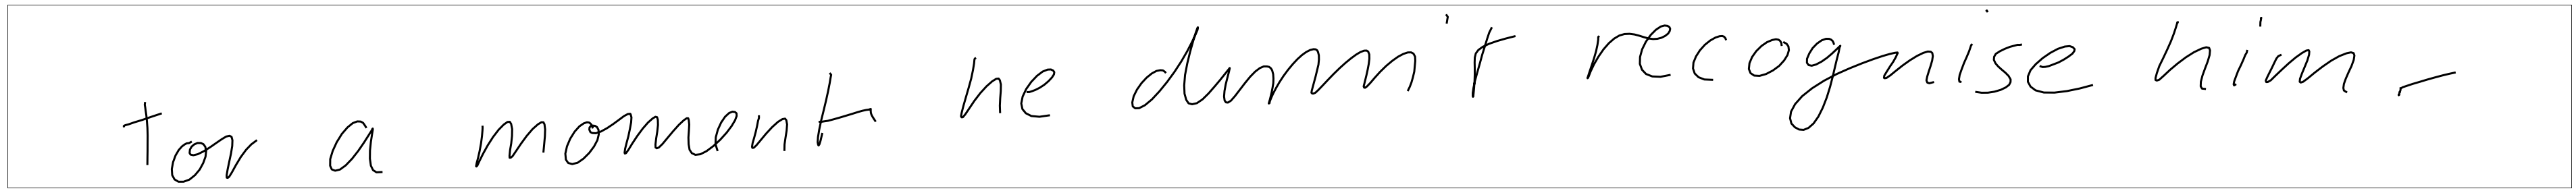

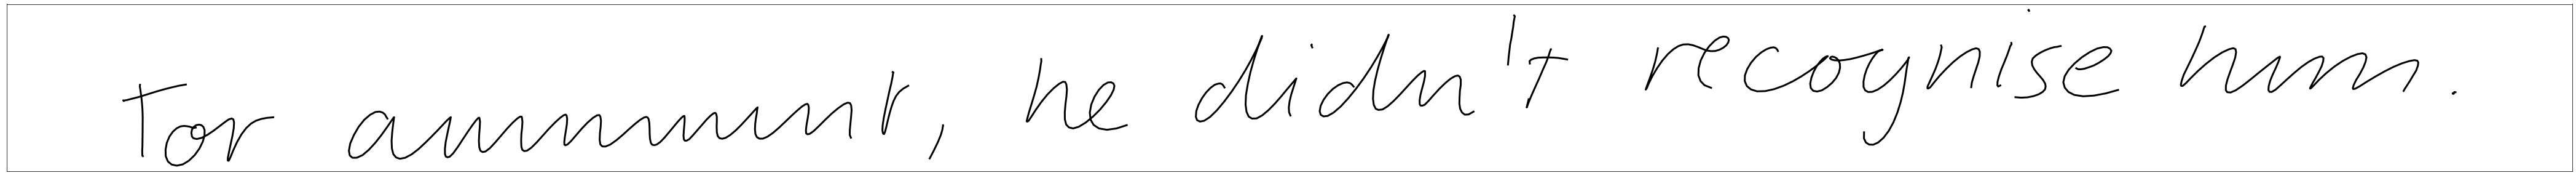

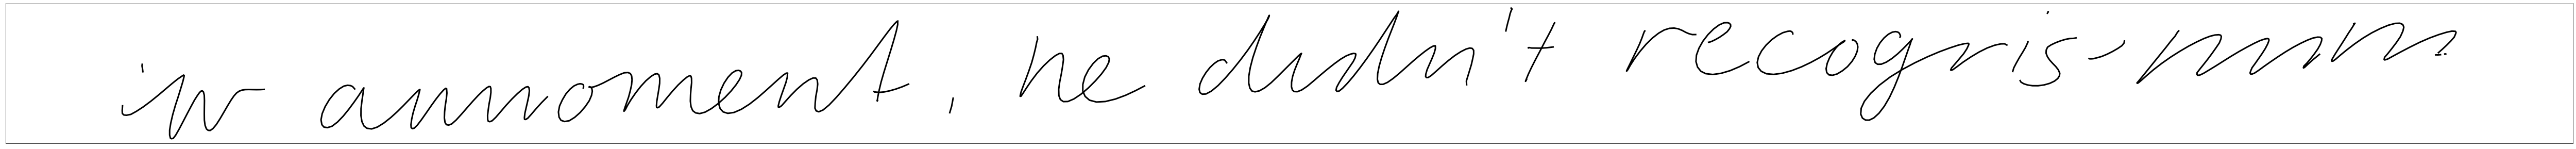

In [14]:
for k in range(3):
  stroke, mix_params, phi, win = sample_congen_primed(lr_model, texts[ind],texts[ind],strokes[ind], char_to_vec, h_size, random_state=10+k, bias1=1000, bias2=1000, time_step=2000)
  plot_stroke(stroke)

### With transition word

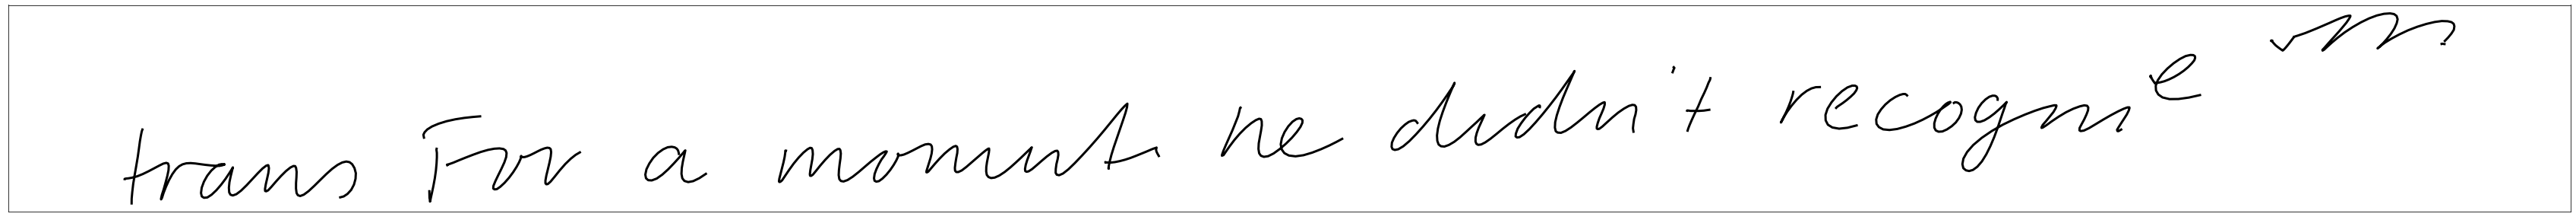

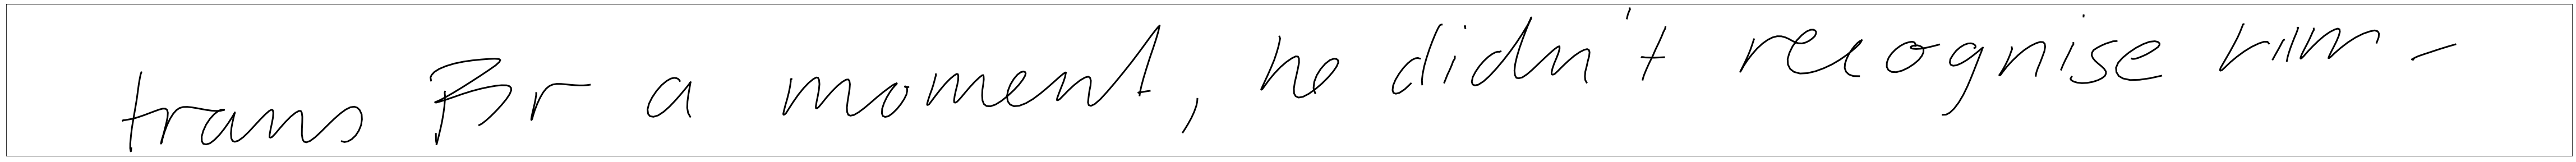

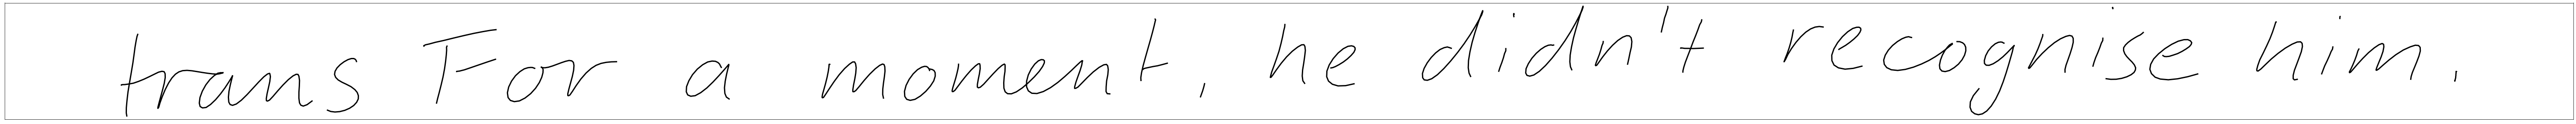

In [15]:
for k in range(3):
  stroke, mix_params, phi, win = sample_congen_primed(lr_model, texts[ind]+' trans ',texts[ind],strokes[ind], char_to_vec, h_size, random_state=13+k, bias1=1000, bias2=1000, time_step=2000)
  plot_stroke(stroke)
 

# Evaluation

In [29]:
import torch
import numpy as np

from eval_hand import load_pretrained_uncond, plot_stroke
from model import mdn_loss, sample_uncond
from data_load import get_strokes_text
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rd_ini=100
lr_model_uncond, h_size_uncond = load_pretrained_uncond('model_uncond_origin.pt')
list_strokes=[]
list_loss=[]

for k in range(20):
  stroke, mix_params, phi, win = sample_congen_primed(lr_model, texts[ind],' trans '+texts[ind],strokes[ind], char_to_vec, h_size, random_state=rd_ini + k, bias1=10, bias2=10, time_step=2000)
  plot_stroke(stroke)
  list_strokes.append(stroke)

  loss = 0
  bi=2
  hidden_size=h_size_uncond
  hidden1 = (torch.zeros(bi, 1, hidden_size, device=device), torch.zeros(bi, 1, hidden_size, device=device))
  hidden2 = (torch.zeros(bi, 1, hidden_size, device=device), torch.zeros(bi, 1, hidden_size, device=device))
  for j in range(len(stroke)-1):
      x = torch.tensor(stroke[j], dtype=torch.float, device=device)
      mdn_params, hidden1, hidden2 = lr_model_uncond(x.unsqueeze(0), hidden1, hidden2)
      loss += mdn_loss(mdn_params, torch.tensor(stroke[None,j+1], dtype=torch.float, device=device))
  loss = loss.item()/len(stroke)
  print(loss)
  print(len(stroke))
  list_loss.append(loss)

Output hidden; open in https://colab.research.google.com to view.

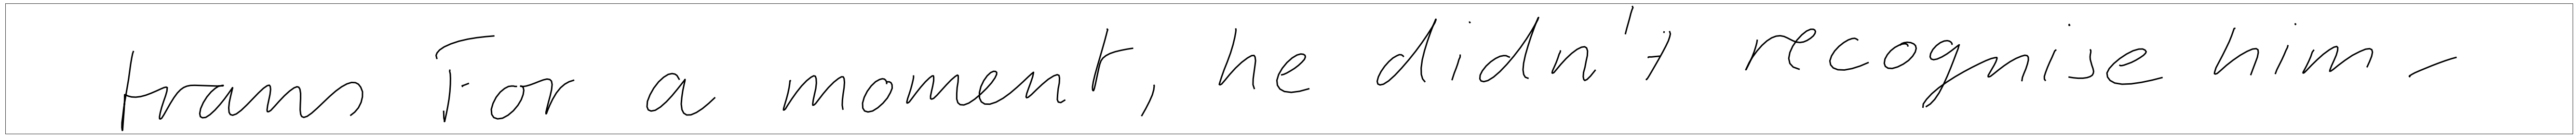

In [32]:
plot_stroke(list_strokes[list_loss.index(max(list_loss))])

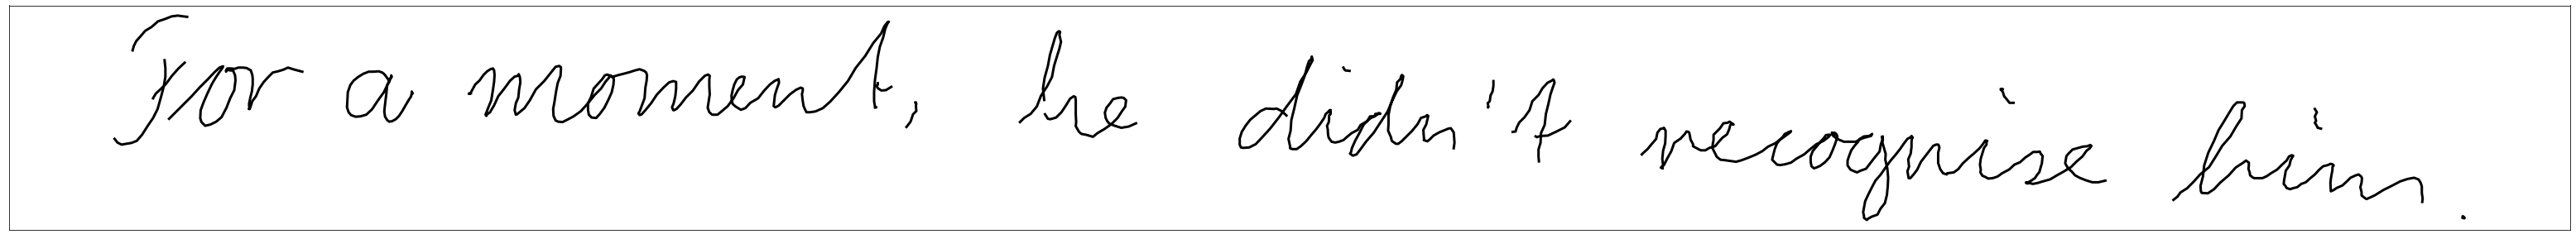

In [33]:
plot_stroke(strokes[ind])

# Shakespeare texts


In [19]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [17]:
#data loading
def data_load():
    shakespeare_url = "https://homl.info/shakespeare"

    filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)

    with open(filepath) as f:
        shakespeare_text = f.read()
        
    tokenizer = keras.preprocessing.text.Tokenizer(char_level = True)
    tokenizer.fit_on_texts([shakespeare_text])
    
    max_id = len(tokenizer.word_index)
    [encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) -1
    print(len(encoded))
    
    dataset_size = len(encoded)
    train_size = dataset_size * 90 // 100
    dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
    
    window_length = 101
    dataset = dataset.window(window_length, shift = 1, drop_remainder = True)
    
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    
    batch_size = 32
    dataset = dataset.shuffle(1000).batch(batch_size)

    dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
    
    dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth = max_id), Y_batch))

    return dataset, tokenizer


dataset, tokenizer = data_load()

1130496/1115394 [==============================] - 0s 0us/step
1115394


In [18]:
max_id = 39

model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences = True, input_shape = [None, max_id], dropout = 0.2, recurrent_dropout = 0.2),
    keras.layers.GRU(128, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation = "softmax"))
    
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam")

In [ ]:
#for training
history = model.fit(dataset, epochs = 2)

In [20]:
#for loading
model.load_weights('saved_model/shakespeare_model.h5')

In [26]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)


def next_char(text, temperature = 1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1, :]
    #print(y_proba)
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(np.matrix(rescaled_logits), num_samples = 1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]


def complete_text(text, n_chars = 100, temperature = 1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text


shakeasperian_text = complete_text("the", temperature = 0.50)

In [27]:
shakeasperian_text.split('\n')

['the virtues speak.',
 '',
 'coriolanus:',
 'what we are we all the gone!',
 '',
 'coriolanus:',
 'i so the sun own all',
 'the peop']

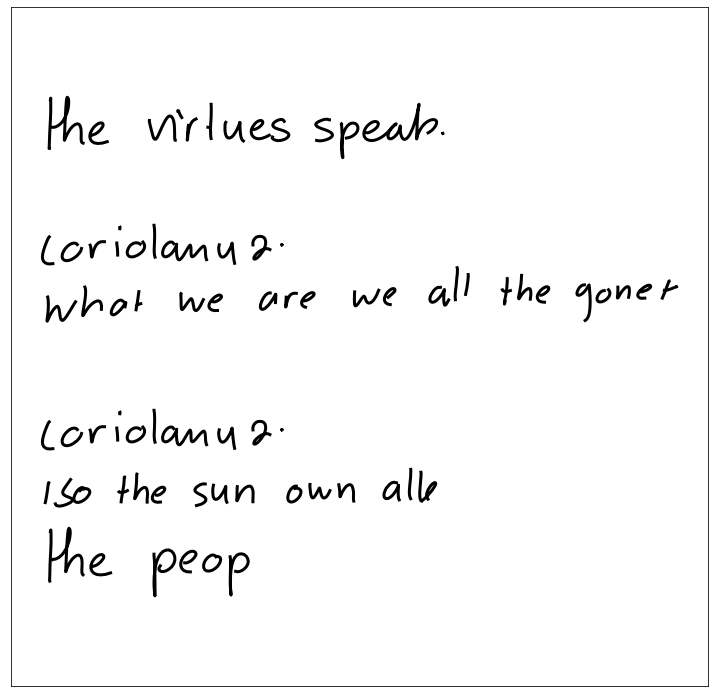

In [28]:
def plot_strokes(l_stroke, save_name=None, lamb = 3):

    f, ax = plt.subplots()
    line = 0
    for stroke in l_stroke:
    # Plot a single example.
        if stroke is not None:
        

            x = np.cumsum(stroke[:, 1])
            y = np.cumsum(stroke[:, 2]) - line

            size_x = x.max() - x.min() + 1.
            size_y = y.max() - y.min() + 1. 

            f.set_size_inches(lamb*5. , lamb*5.)

            cuts = np.where(stroke[:, 0] == 1)[0]
            start = 0

            for cut_value in cuts:
                ax.plot(lamb*x[start:cut_value], lamb*y[start:cut_value],
                        'k-', linewidth=3)
                start = cut_value + 1
            ax.axis('equal')
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
        
        line += 1000
    plt.show()



l_stroke = []
for text in shakeasperian_text.split("\n"):
    if text == "":
        l_stroke.append(None)
    else :
        strokes, mix_params, phi, win = sample_congen(lr_model, text, char_to_vec, h_size, bias1 = 4,  bias2 = 2, time_step = 4000)
        l_stroke.append(strokes)


plot_strokes(l_stroke, lamb = 2.5)